In [142]:
import pandas as pd
import numpy as np
import os, gc, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib.font_manager import FontManager, FontProperties
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from matplotlib.font_manager import FontManager, FontProperties
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import emoji, requests
import subprocess
import tempfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# For English stopwords
from nltk.corpus import stopwords
os.chdir("C:\\Users\\Peter_PPT\\OneDrive\\Courses\\MMDT Deep Learning_ ML\\project\\")

# Data collection

In [122]:
datapath = os.path.join(os.getcwd(),'data')
figpath = os.path.join(os.getcwd(),'fig')
files = ['ltrain.txt','ltest.txt','strain.txt','stest.txt']
gc.enable()

In [68]:
ldf = pd.DataFrame()
sdf = pd.DataFrame()
for file in files:
    if 'ltrain' in file or 'ltest' in file:
        ftype = 'long'
        print(f'processing long file: {file}')
    else:
        ftype = 'short'
        print(f'processing short file: {file}')
    with open(os.path.join(datapath,file), 'r') as f:
        file_content = f.readlines()
    for i, line in enumerate(file_content):
        file_content[i] = line.strip()
    labellist = []
    textlist = []
    for content in file_content:
        label = content.split("__label__")[1].split(" ")[0]
        text = " ".join(content.split("__label__")[1].split(" ")[1:])
        labellist.append(label)
        textlist.append(text)
    df = pd.DataFrame()
    df['text'] = textlist
    df['label'] = labellist
    if ftype=='long':
        print("concat to long")
        ldf = pd.concat([ldf,df])
    else: 
        print("concat to short")
        sdf = pd.concat([sdf,df])
print(f"all short file: {sdf.shape}: \t {sdf.head(3)}")
print(f"all long file: {ldf.shape}: \t {ldf.head(3)}")
ldf = ldf.reset_index(drop=True)
sdf = sdf.reset_index(drop=True)
ldf.to_csv(os.path.join(datapath,'longtext_org.csv'),index=False)
sdf.to_csv(os.path.join(datapath,'shorttext_org.csv'),index=False)
del labellist, textlist, df
gc.collect()

processing long file: ltrain.txt
concat to long
processing long file: ltest.txt
concat to long
processing short file: strain.txt
concat to short
processing short file: stest.txt
concat to short
all short file: (10137, 2): 	                  text label
0  လီး တောင် မ လီး ပဲ    ab
1  လောက် ဆောက်ရှက်ခွဲ    ab
2             သေခါနီး    ab
all long file: (10137, 2): 	                                                 text label
0       လီး တောင် ရိုးရိုး မ ဟုတ် ဘူး တပတ်လည် လီး ပဲ    ab
1  ဆူ စရာ ရှိ လည်း ကွယ်ရာ မှာ ပြော ပါ လား ကွာ စိတ...    ab
2                     သေခါနီး ရိက္ခာ ယူ နေ ကြ တယ် GL    ab


9455


The following rows are duplicates and their indices will be dropped:
Indices to be dropped: [5327, 6851, 8592, 8965, 9007, 9904, 9947]

Content of the duplicate rows to be dropped:
                                                                text label
5327                                                         ဖေလိုးမ    ab
6851                                       အဲ့ တာ လီး လုပ် ရ မှာ လား    ab
8592                                                စောက်ပေါ လင်မယား    ab
8965                                                မင်းမေလိုး လိုက်    ab
9007                                         လီးရုပ် က လီးရုပ် ပါ ပဲ    bo
9904  နင် တို့ လည်း နော် ကြီးကောင်ကြီးမား တွေ နဲ့ တော်ရုံပဲရူး ကြ ပါ    ab
9947                                                          အောလီမ    ab

Number of duplicate rows dropped: 7
Final number of rows before dropping duplicates in longtxt: 10137
Final number of rows before dropping duplicates in shorttxt: 10137
Final number of rows after dropping duplicates i

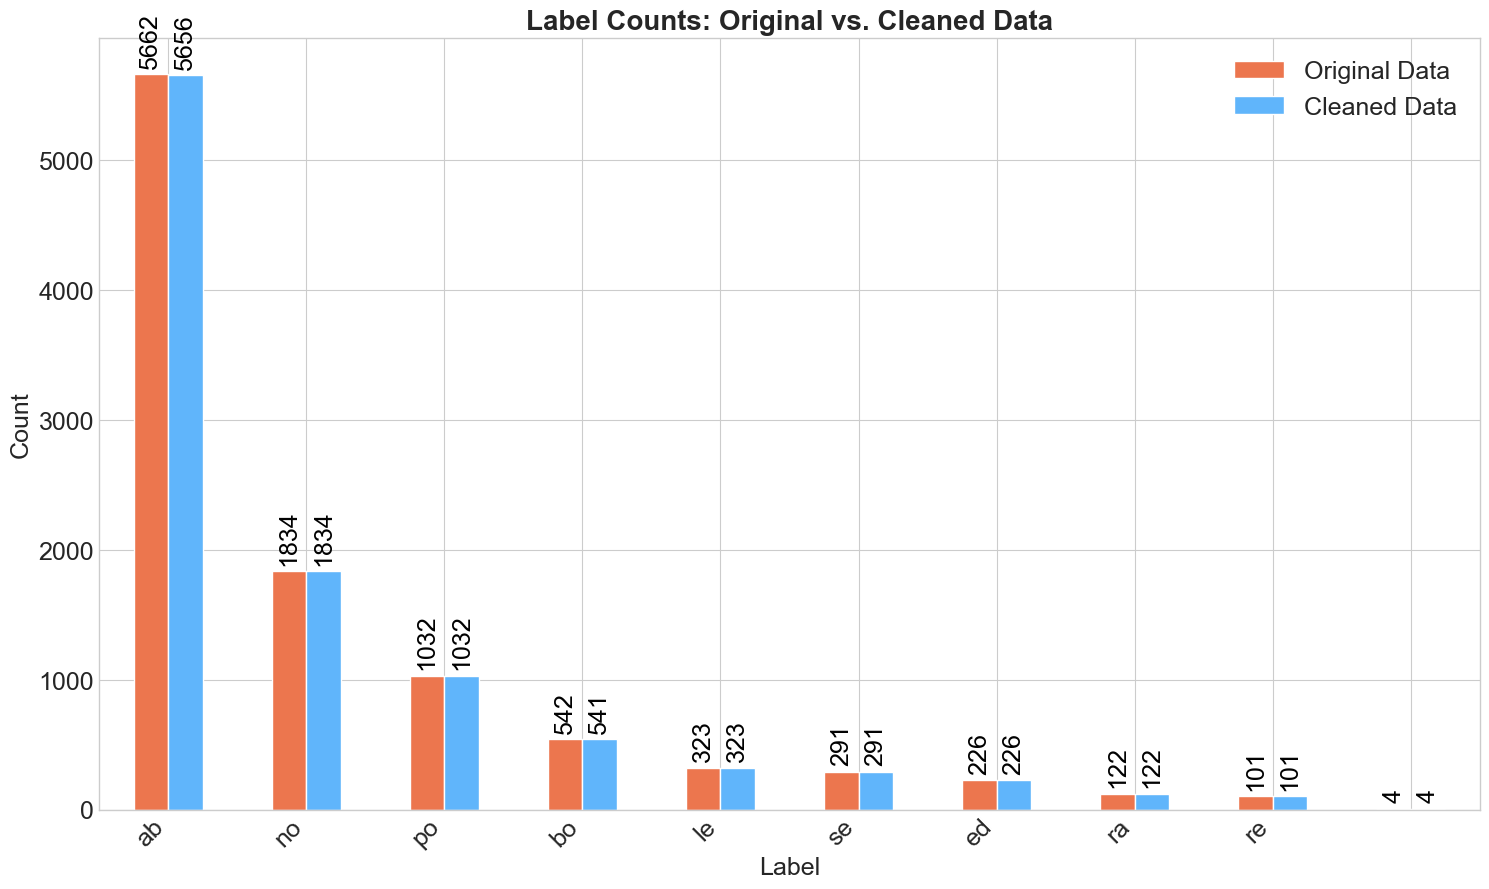

The comparison bar chart with rotated counts has been saved as 'original_vs_cleaned_distribution_rotated.png'


In [69]:
## Handling duplicated row
initial_rows = len(ldf)
## get the index to be dropped
dropped_indices = ldf[ldf.duplicated()].index.tolist()

if dropped_indices:
    print("\nThe following rows are duplicates and their indices will be dropped:")
    print(f"Indices to be dropped: {dropped_indices}")
    # Display the full rows that are marked as duplicates
    duplicate_rows_to_drop = ldf.loc[dropped_indices].to_string()
    print("\nContent of the duplicate rows to be dropped:")
    print(duplicate_rows_to_drop)
else:
    print("\nNo duplicate rows found.")

# Drop the duplicate rows, keeping the first occurrence
ldf_cleaned = ldf.drop_duplicates(keep='first').reset_index(drop=True)
sdf_cleaned = sdf.drop(dropped_indices).reset_index(drop=True)
# Print the number of rows dropped
rows_dropped = initial_rows - len(ldf_cleaned)
print(f"\nNumber of duplicate rows dropped: {rows_dropped}")
print(f"Final number of rows before dropping duplicates in longtxt: {len(ldf)}")
print(f"Final number of rows before dropping duplicates in shorttxt: {len(sdf)}")
print(f"Final number of rows after dropping duplicates in longtxt: {len(ldf_cleaned)}")
print(f"Final number of rows after dropping duplicates in shorttxt: {len(sdf_cleaned)}")
print("-" * 30)
print(ldf_cleaned)
print("---")
print(sdf_cleaned)
sdf_cleaned.to_csv(os.path.join(datapath,'shorttext_clean.csv'),index=False)
ldf_cleaned.to_csv(os.path.join(datapath,'longtext_clean.csv'),index=False)

## visualize

# --- Prepare data for plotting ---
# Get the value counts for the 'label' column from both dataframes
label_counts_initial = ldf['label'].value_counts()
label_counts_cleaned = ldf_cleaned['label'].value_counts()

# Combine the two series into a single DataFrame for easy plotting
# This ensures that the labels are correctly aligned for both datasets
comparison_df = pd.DataFrame({
    'Original Data': label_counts_initial,
    'Cleaned Data': label_counts_cleaned
}).fillna(0).astype(int) # Fill NaNs with 0 in case a label was removed entirely

# --- Visualize the data with specified font sizes and rotated counts ---
# Plot a single bar chart comparing the two dataframes
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 9)) # Set figure size to 12, 8

# Plot the bars for both 'Original' and 'Cleaned' data
bars = comparison_df.plot(
    kind='bar',
    ax=ax,
    color=["#EC764E", "#60B5FB"],
    rot=45,
    fontsize=18 # Set x-tick label font size
)

# Set the title and labels with specified font sizes
ax.set_title('Label Counts: Original vs. Cleaned Data', fontsize=20, weight='bold')
ax.set_xlabel('Label', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.tick_params(axis='y', labelsize=18) # Set y-tick label font size
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=18)

# Add the count value on top of each bar, rotated by 90 degrees
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2, # x-position of the text
        bar.get_height() + 50, # y-position (slightly above the bar)
        int(bar.get_height()), # The text to display (the count value)
        ha='center', # Horizontal alignment
        va='bottom', # Vertical alignment
        fontsize=18, # Set the text label font size
        color='black',
        rotation=90 # Rotate the text by 90 degrees
    )

# Adjust layout and save the figure
plt.tight_layout()
plt.legend(fontsize=18)
plt.savefig(os.path.join(figpath,'original_vs_cleaned_distribution_rotated.png'))
plt.show()

print("The comparison bar chart with rotated counts has been saved as 'original_vs_cleaned_distribution_rotated.png'")


In [70]:

# Get the top 3 most frequent labels
label_counts = ldf_cleaned['label'].value_counts()
top_3_labels = label_counts.nlargest(3).index.tolist()
print(top_3_labels)
# Filter the DataFrame to keep only the top 3 classes
ldf_clean_top3 = ldf_cleaned[ldf_cleaned['label'].isin(top_3_labels)].copy()
sdf_clean_top3 = sdf_cleaned[sdf_cleaned['label'].isin(top_3_labels)].copy()
ldf_clean_top3 = ldf_clean_top3.reset_index(drop=True)
sdf_clean_top3 = sdf_clean_top3.reset_index(drop=True)
# Save the top 3 data to a new CSV file
print(ldf_clean_top3)
print("-----")
print(sdf_clean_top3)
ldf_clean_top3.to_csv(os.path.join(datapath,'longtext_cleaned_top3.csv'), index=False)
sdf_clean_top3.to_csv(os.path.join(datapath,'shorttext_cleaned_top3.csv'), index=False)
print("\nDataFrame with top 3 classes saved to 'longtext_cleaned_top3.csv'")
print("Top 3 classes distribution:")
print(ldf_clean_top3['label'].value_counts())


['ab', 'no', 'po']
                                                   text label
0          လီး တောင် ရိုးရိုး မ ဟုတ် ဘူး တပတ်လည် လီး ပဲ    ab
1     ဆူ စရာ ရှိ လည်း ကွယ်ရာ မှာ ပြော ပါ လား ကွာ စိတ...    ab
2                        သေခါနီး ရိက္ခာ ယူ နေ ကြ တယ် GL    ab
3     အောက်တန်းစား စိတ်ဓာတ် တွေ ဖာဆန် တဲ့ လုပ်ရပ် နဲ...    ab
4     စာအုပ် အဟောင်း သတင်းစာ အဟောင်း ပဲ ကျန် တော့ မှ...    no
...                                                 ...   ...
8517                   မိမွေးတိုင်းဖမွေးတိုင်းလေး 😁 😁 😁    ab
8518         သောက်တလွဲ ဘာ ethics မှ မ ရှိ တဲ့ ကောင် တွေ    ab
8519                       အဆဲ ခံ ဖို့ သက်သက် xင်ယား တာ    ab
8520  8 နာရီ ကျော် နေ ပြီ လေ ပြန် လာ လား ? Kmkl များ...    ab
8521  မ နိုင် တာ သိ လို့ ဘုရင် စနစ် နဲ့ ကိုင် ပြီး ခ...    no

[8522 rows x 2 columns]
-----
                                                   text label
0                                    လီး တောင် မ လီး ပဲ    ab
1                                    လောက် ဆောက်ရှက်ခွဲ    ab
2                   

Index(['original_index', 'text_long', 'label_long', 'text_short',
       'label_short'],
      dtype='object')
      original_index                                          text_long  \
0                  0       လီး တောင် ရိုးရိုး မ ဟုတ် ဘူး တပတ်လည် လီး ပဲ   
1                  1  ဆူ စရာ ရှိ လည်း ကွယ်ရာ မှာ ပြော ပါ လား ကွာ စိတ...   
2                  2                     သေခါနီး ရိက္ခာ ယူ နေ ကြ တယ် GL   
3                  3  အောက်တန်းစား စိတ်ဓာတ် တွေ ဖာဆန် တဲ့ လုပ်ရပ် နဲ...   
4                  4  စာအုပ် အဟောင်း သတင်းစာ အဟောင်း ပဲ ကျန် တော့ မှ...   
...              ...                                                ...   
8517            8517                   မိမွေးတိုင်းဖမွေးတိုင်းလေး 😁 😁 😁   
8518            8518         သောက်တလွဲ ဘာ ethics မှ မ ရှိ တဲ့ ကောင် တွေ   
8519            8519                       အဆဲ ခံ ဖို့ သက်သက် xင်ယား တာ   
8520            8520  8 နာရီ ကျော် နေ ပြီ လေ ပြန် လာ လား ? Kmkl များ...   
8521            8521  မ နိုင် တာ သိ လို့ ဘုရင် စနစ် နဲ့ ကိုင် ပြ

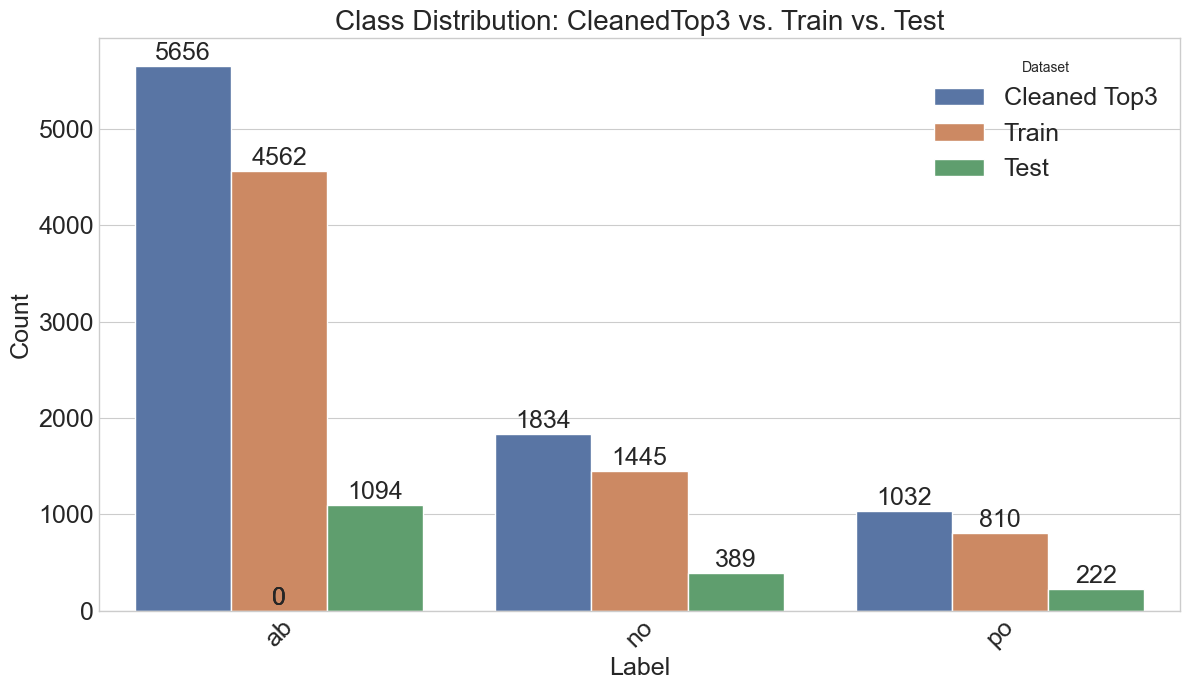

In [71]:
## split the training and test
combined_top3df = pd.DataFrame()
top3_ldf = ldf_clean_top3.copy()
top3_ldf['original_index']= top3_ldf.index
top3_ldf = top3_ldf.set_index('original_index').add_suffix('_long').reset_index()

top3_sdf = sdf_clean_top3.copy()
top3_sdf['original_index']= top3_sdf.index
top3_sdf = top3_sdf.set_index('original_index').add_suffix('_short').reset_index()

combined_top3df = pd.merge(top3_ldf, top3_sdf, on='original_index', how='left')

# combined_top3df = pd.merge(top3_ldf[['original_index']], top3_sdf, on='original_index', how='left')
print(combined_top3df.columns)
print(combined_top3df)

### split to train and text

X = combined_top3df[['text_long', 'text_short']]
y = combined_top3df[['label_long', 'label_short']]

# --- Step 3: Perform the 80/20 train-test split ---
# We use the train_test_split function from scikit-learn.
# - test_size=0.2 specifies that 20% of the data should be for testing.
# - random_state=42 ensures the split is the same every time you run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
### save the test file
ltest = pd.DataFrame()
ltest['text']=X_test['text_long']
ltest['label']=y_test['label_long']
ltest= ltest.reset_index(drop=True)
stest = pd.DataFrame()
stest['text']=X_test['text_short']
stest['label']=y_test['label_short']
stest = stest.reset_index(drop=True)
ltest.to_csv(os.path.join(datapath,'longtext_test.csv'),index=False)
stest.to_csv(os.path.join(datapath,'shorttext_test.csv'),index=False)

### training file
ltrain = pd.DataFrame()
ltrain['text']=X_train['text_long']
ltrain['label']=y_train['label_long']
ltrain = ltrain.reset_index(drop=True)
strain = pd.DataFrame()
strain['text']=X_train['text_short']
strain['label']=y_train['label_short']
strain = strain.reset_index(drop=True)
print(ltrain.shape)
print(strain.shape)
print(ltrain)
print("-----")
print(strain)
### visualize the train test data

# --- Step 3: Calculate class counts for each dataset ---
original_counts = ldf_clean_top3['label'].value_counts().rename('Cleaned Top3').sort_index()
train_counts = ltrain['label'].value_counts().rename('Train').sort_index()
test_counts = ltest['label'].value_counts().rename('Test').sort_index()

# Combine the counts into a single DataFrame for plotting
counts_df = pd.concat([original_counts, train_counts, test_counts], axis=1).fillna(0)

print("Combined Class Counts for Visualization:")
print(counts_df)
print("-" * 40)

# --- Step 4: Visualize the data ---
# We'll use a grouped bar chart to compare the class distributions.
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# The fix is here: 'label' is now the column to melt on, not 'index'.
plot_df = counts_df.reset_index().melt('label', var_name='Dataset', value_name='Count')

barplot = sns.barplot(x='label', y='Count', hue='Dataset', data=plot_df, palette='deep')

# Add the count values on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points',
                     fontsize=18)

plt.title('Class Distribution: CleanedTop3 vs. Train vs. Test',fontsize=20)
plt.xlabel('Label',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.xticks(rotation=45,fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Dataset',fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(figpath,'Cleantop3_train_test_distribution.png'))
plt.show()


In [72]:
print(counts_df)

       Cleaned Top3  Train  Test
label                           
ab             5656   4562  1094
no             1834   1445   389
po             1032    810   222


                                                   text label  original_index
0             ဖာ အားပေး မ လား မင်း က ပြော လက်စ ညီမပေး 😔    ab            5979
1     ဆရာဝန် မှတ် က မှီ မှာ ပါ ဒါ ကျက် ဒါ ဖြေ ကြီး ပ...    po            3296
2     ဖက်တီး က ဘို လို မ မှုတ် နဲ့ လေ ငါ လီး က တည်း ...    ab            3261
3     တရုတ် ဖျင်ခံ နေ တဲ့ စစ်ခွေး တွေ ပဲ ဒီမို စစ်စစ...    po            4725
4                                  ၀က်ရူးပြန် နေ တာ လား    no            2093
...                                                 ...   ...             ...
5995  အရမ်း ကို လူမဆန် တာ ဒါ ဘာသာ ရေး အမည်ခံ ပြီး စီ...    po             418
5996  နင် တို့ ဘာ ဖြစ် နေ ကြ တာ လဲ ဟင် မ သိ လို့ နော...    no            3399
5997                  နင် လား ငါ လား ပဲ နော် မြန်မာ နဲ့    no            5532
5998  ဒီ လောက် ကျက်သရေ ရှိ တဲ့ post က ဘာ တွေ များ ရု...    no            5981
5999  အရင် တည်းက လှ လို့ သဘောကျ ပေမဲ့ စောက်ကြောတင်း ...    ab            3858

[6000 rows x 3 columns]
The bar chart has been saved as 'class_

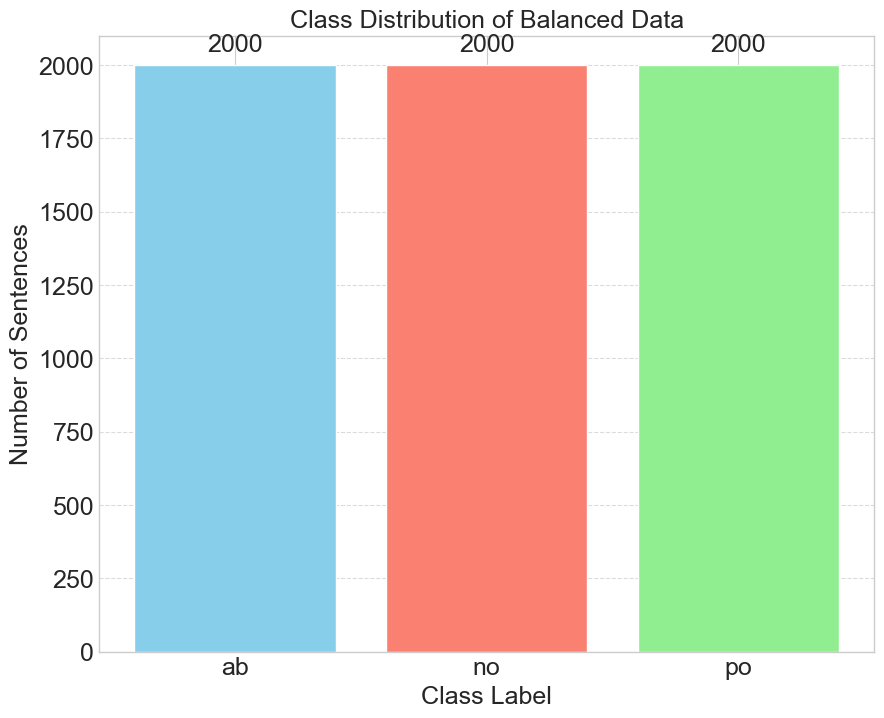

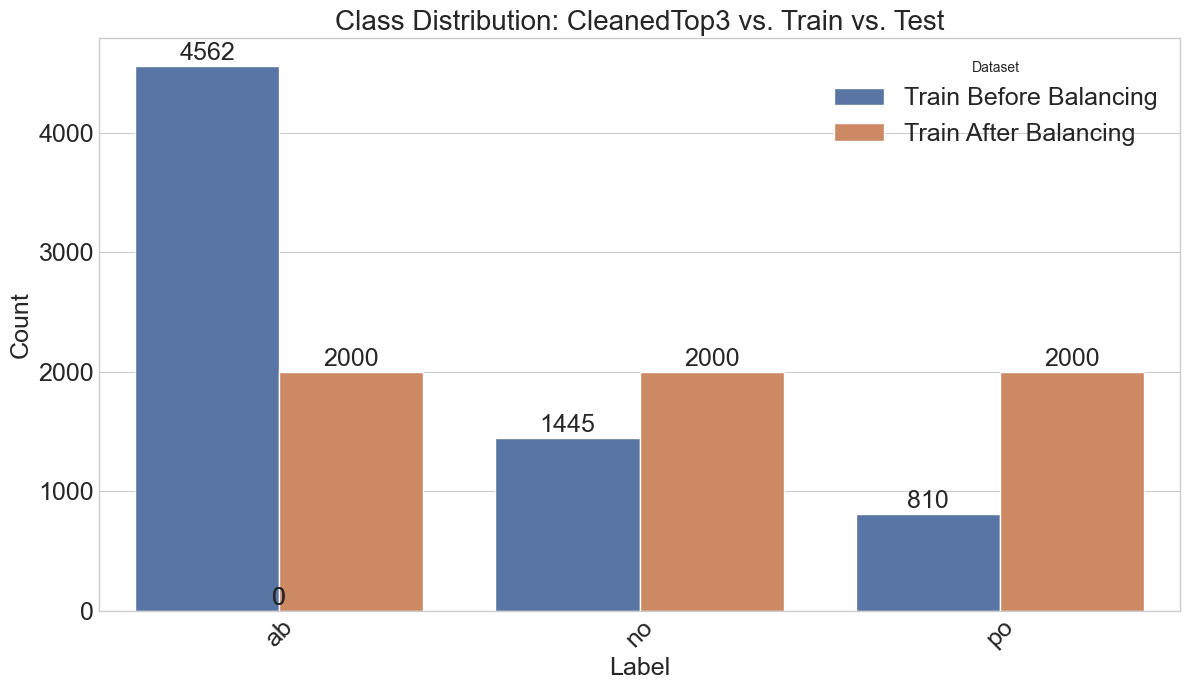

In [73]:
### Make balance data
filtered_ldf = ltrain.copy()
filtered_sdf = strain.copy()
filtered_ldf['original_index']=filtered_ldf.index
filtered_sdf['original_index']=filtered_sdf.index
# Define the target number of samples for each class
target_count = 2000

# Initialize an empty list to store the resampled longtext dataframes
resampled_ldf_list = []

# Perform bootstrapping on the longtext data to balance the classes
for label in ['ab', 'po', 'no']:
    class_df = filtered_ldf[filtered_ldf['label'] == label]
    # Use the sample method with `replace=True` for bootstrapping
    resampled_class_df = class_df.sample(n=target_count, replace=True, random_state=42)
    resampled_ldf_list.append(resampled_class_df)

# Concatenate all the resampled longtext dataframes to create the balanced longtext dataframe
balanced_ldf = pd.concat(resampled_ldf_list)

# Shuffle the balanced longtext dataframe to mix the classes
balanced_ldf = balanced_ldf.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_ldf)
# Use the 'original_index' from the balanced longtext dataframe to get the corresponding shorttext rows
balanced_sdf = pd.merge(balanced_ldf[['original_index']], filtered_sdf, on='original_index', how='left')

# The final dataframes 'balanced_ldf' and 'balanced_sdf' now have 2000 rows each for
# 'ab', 'po', and 'no' classes, with their rows perfectly matched.

# You can save these to new CSV files if needed
balanced_ldf.to_csv(os.path.join(datapath,'balanced_longtext_train.csv'), index=False)
balanced_sdf.to_csv(os.path.join(datapath,'balanced_shorttext_train.csv'), index=False)


# --- Visualization section with increased font sizes ---
class_counts = balanced_ldf['label'].value_counts().sort_index()
labels = class_counts.index
counts = class_counts.values

plt.figure(figsize=(10, 8))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])

# Add labels and title with larger font sizes
plt.title('Class Distribution of Balanced Data', fontsize=18)
plt.xlabel('Class Label', fontsize=18)
plt.ylabel('Number of Sentences', fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Add count value on top of each bar with a larger font size
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 30, yval, ha='center', va='bottom', fontsize=18)

# Save the plot to a file
plt.savefig(os.path.join(figpath,'balanced class_distribution.png'))

print("The bar chart has been saved as 'class_distribution_large_font.png'")

### visualize before and after

# --- Step 3: Calculate class counts for each dataset ---
before_counts = filtered_ldf['label'].value_counts().rename('Train Before Balancing').sort_index()
after_counts = balanced_ldf['label'].value_counts().rename('Train After Balancing').sort_index()

# Combine the counts into a single DataFrame for plotting
counts_df = pd.concat([before_counts, after_counts], axis=1).fillna(0)

print("Combined Class Counts for Visualization:")
print(counts_df)
print("-" * 40)

# --- Step 4: Visualize the data ---
# We'll use a grouped bar chart to compare the class distributions.
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# The fix is here: 'label' is now the column to melt on, not 'index'.
plot_df = counts_df.reset_index().melt('label', var_name='Dataset', value_name='Count')

barplot = sns.barplot(x='label', y='Count', hue='Dataset', data=plot_df, palette='deep')

# Add the count values on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points',
                     fontsize=18)

plt.title('Class Distribution: CleanedTop3 vs. Train vs. Test',fontsize=20)
plt.xlabel('Label',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.xticks(rotation=45,fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Dataset',fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(figpath,'Train_before_after_balancing_distribution.png'))
plt.show()


# Analysis part

### Data Preprocessing and exploration

In [123]:
trainfilename = 'balanced_shorttext_train.csv'
trainfilename = 'balanced_longtext_train.csv'
testfilename = 'longtext_test.csv'
datapath = os.path.join(os.getcwd(),'data')
figpath = os.path.join(os.getcwd(),'fig')

try:
    train_df = pd.read_csv(os.path.join(datapath,trainfilename))
    test_df = pd.read_csv(os.path.join(datapath,testfilename))
except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure the files are in the correct directory.")


In [140]:
def myanmar_preprocess(text):
    # Remove English letters, numbers, and most punctuation (keep Myanmar chars)
    text = re.sub(r'[a-zA-Z0-9]+', '', str(text))
    text = re.sub(r'[!-/:-@[-`{-~]', '', text)  # Remove ASCII punctuation
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    text = text.strip()
    return text

In [147]:

train_df['clean_text'] = train_df['text'].apply(myanmar_preprocess)
test_df['clean_text'] = test_df['text'].apply(myanmar_preprocess)
print(train_df[['text', 'clean_text']].head())


                                                text  \
0          ဖာ အားပေး မ လား မင်း က ပြော လက်စ ညီမပေး 😔   
1  ဆရာဝန် မှတ် က မှီ မှာ ပါ ဒါ ကျက် ဒါ ဖြေ ကြီး ပ...   
2  ဖက်တီး က ဘို လို မ မှုတ် နဲ့ လေ ငါ လီး က တည်း ...   
3  တရုတ် ဖျင်ခံ နေ တဲ့ စစ်ခွေး တွေ ပဲ ဒီမို စစ်စစ...   
4                               ၀က်ရူးပြန် နေ တာ လား   

                                          clean_text  
0          ဖာ အားပေး မ လား မင်း က ပြော လက်စ ညီမပေး 😔  
1  ဆရာဝန် မှတ် က မှီ မှာ ပါ ဒါ ကျက် ဒါ ဖြေ ကြီး ပ...  
2  ဖက်တီး က ဘို လို မ မှုတ် နဲ့ လေ ငါ လီး က တည်း ...  
3  တရုတ် ဖျင်ခံ နေ တဲ့ စစ်ခွေး တွေ ပဲ ဒီမို စစ်စစ...  
4                               ၀က်ရူးပြန် နေ တာ လား  


In [148]:
## Encode labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])
print(train_df[['label', 'label_encoded']].head())

  label  label_encoded
0    ab              0
1    po              2
2    ab              0
3    po              2
4    no              1


In [149]:

# 3. Feature extraction for ML
vectorizer = TfidfVectorizer(max_features=5000)
X_train_ml = vectorizer.fit_transform(train_df['clean_text'])
X_test_ml = vectorizer.transform(test_df['clean_text'])
y_train_ml = train_df['label_encoded']
y_test_ml = test_df['label_encoded']

In [150]:

# Show the first 20 words in the TF-IDF vocabulary
vocab = vectorizer.vocabulary_
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1])
print("TF-IDF Vocabulary (first 20):")
for word, idx in sorted_vocab[:20]:
    print(f"{idx}: {word}")

# Optionally, show the top 20 words by average TF-IDF score in the training set
tfidf_means = np.asarray(X_train_ml.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[::-1][:20]
feature_names = vectorizer.get_feature_names_out()
print("\nTop 20 words by average TF-IDF score:")
for idx in top_indices:
    print(f"{feature_names[idx]}: {tfidf_means[idx]:.4f}")

TF-IDF Vocabulary (first 20):
0: ကက
1: ကခ
2: ကင
3: ကငယ
4: ကစ
5: ကစဉ
6: ကတ
7: ကတက
8: ကတင
9: ကတည
10: ကတန
11: ကထ
12: ကန
13: ကနင
14: ကနတ
15: ကပ
16: ကပစ
17: ကဖင
18: ကမ
19: ကမကလ

Top 20 words by average TF-IDF score:
တယ: 0.0846
လည: 0.0496
ရင: 0.0460
တစ: 0.0429
မယ: 0.0382
မင: 0.0370
စစ: 0.0365
ဘယ: 0.0331
အမ: 0.0322
အက: 0.0286
နင: 0.0276
အခ: 0.0276
မအလ: 0.0272
အတ: 0.0234
တပ: 0.0225
စရ: 0.0210
သတ: 0.0202
ကလ: 0.0200
အရ: 0.0186
မအ: 0.0181


In [ ]:


# 4. Train ML models
ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
}
ml_results = {}
for name, model in ml_models.items():
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test_ml, y_pred, target_names=le.classes_))
    ml_results[name] = model

# 5. Prepare data for DL
VOCAB_SIZE = 10000
MAX_LEN = 100
EMBEDDING_DIM = 128
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')
y_train_dl = train_df['label_encoded']
y_test_dl = test_df['label_encoded']

# 6. Build and train DL model
dl_model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])
dl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
dl_model.fit(X_train_pad, y_train_dl, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test_dl), callbacks=[early_stop])

# 7. Evaluate DL model
y_pred_dl = np.argmax(dl_model.predict(X_test_pad), axis=1)
print("\nDeep Learning (Bi-LSTM) Classification Report:")
print(classification_report(y_test_dl, y_pred_dl, target_names=le.classes_))

# 8. Predict a new sentence
def predict_all_models(sentence):
    cleaned = preprocess_text(sentence)
    print(f"\nInput: {sentence}\nCleaned: {cleaned}")
    # ML predictions
    vec = vectorizer.transform([cleaned])
    for name, model in ml_results.items():
        pred = le.inverse_transform(model.predict(vec))[0]
        print(f"{name} Prediction: {pred}")
    # DL prediction
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    dl_pred = le.inverse_transform([np.argmax(dl_model.predict(pad), axis=1)[0]])[0]
    print(f"Deep Learning Prediction: {dl_pred}")

# Example usage:
predict_all_models("ဒီစာကြောင်းကို စမ်းသပ်ကြည့်ပါ။")

In [ ]:
##3. 

  label  label_encoded
0    ab              0
1    po              2
2    ab              0
3    po              2
4    no              1
